<a href="https://colab.research.google.com/github/project-ida/two-state-quantum-systems/blob/master/05-excitation-transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <a href="https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/05-excitation-transfer.ipynb" target="_parent"><img src="https://nbviewer.jupyter.org/static/img/nav_logo.svg" alt="Open In nbviewer" width="100"/></a>

# 5 - Excitation transfer

> TODO: Description

In [1]:
# Libraries
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from IPython.display import Image
import gif
import numpy as np
import pandas as pd
from qutip import *
import warnings
warnings.filterwarnings('ignore')
from itertools import product
import os

# Functions created in 04 tutorial

from libs.helper_05_tutorial import *

H_latex = "$H = (\Delta E / 2) \sigma_z + \hbar\omega(a^{{\dagger}}a +1/2) + U( a^{{\dagger}} + a )\sigma_x$"


In [2]:
def make_operators(max_bosons, parity=0):
    
    a        = tensor(destroy(max_bosons+1), qeye(2), qeye(2))     # tensorised boson destruction operator
    number   = tensor(num(max_bosons+1), qeye(2), qeye(2))         # tensorised boson number operator
    sx1      = tensor(qeye(max_bosons+1), sigmax(), qeye(2))       # tensorised sigma_x operator 1
    sx2      = tensor(qeye(max_bosons+1), qeye(2), sigmax())       # tensorised sigma_x operator 2
    sz1      = tensor(qeye(max_bosons+1), sigmaz(), qeye(2))        # tensorised sigma_z operator 1 
    sz2      = tensor(qeye(max_bosons+1), qeye(2), sigmaz())        # tensorised sigma_z operator 2
    sy1      = tensor(qeye(max_bosons+1), sigmay(), qeye(2))       # tensorised sigma_x operator 1
    sy2      = tensor(qeye(max_bosons+1), qeye(2), sigmay())       # tensorised sigma_x operator 2
    
    two_state_1    =    1/2*sz1                # two state system energy operator 1
    two_state_2    =    1/2*sz2                # two state system energy operator 2
    bosons         =   (number+0.5)             # boson energy operator
    interaction_1  =    (a.dag() + a) * sx1     # interaction energy operator 1
    interaction_2  =    (a.dag() + a) * sx2     # interaction energy operator 2 
    
    P = sz1*sz2*(1j*np.pi*number).expm()                      # parity operator 
    
    
    S2 = (sx1/2+sx2/2)**2 + (sy1/2+sy2/2)**2 + (sz1/2+sz2/2)**2
    
    # map from QuTiP number states to |n,±> states
    possible_ns = range(0, max_bosons+1)
    possible_ms = ["+","-"]
    nm_list = [(n,m1,m2) for (n,m1,m2) in product(possible_ns, possible_ms, possible_ms)]
    
    # only do parity extraction if a valid parity is being used
    if (parity==1) | (parity==-1):
        p           = np.where(P.diag()==parity)[0]
        
        two_state_1     = two_state_1.extract_states(p)
        two_state_2     = two_state_2.extract_states(p)
        bosons          = bosons.extract_states(p)
        number          = number.extract_states(p)
        interaction_1   = interaction_1.extract_states(p)
        interaction_2   = interaction_2.extract_states(p)
        S2              = S2.extract_states(p)
        P               = P.extract_states(p)
        nm_list         = [nm_list[i] for i in p]
    
    
    return two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nm_list, P, S2

In [3]:
def make_braket_labels(nm_list):
    bra_labels = ["$\langle$"+str(n)+", "+str(m1)+", "+str(m2)+" |" for (n,m1,m2) in nm_list]
    ket_labels = ["| "+str(n)+", "+str(m1)+", "+str(m2)+"$\\rangle$" for (n,m1,m2) in nm_list]
    return bra_labels, ket_labels

In [106]:
two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nm_list, parity, S2= make_operators(max_bosons=2, parity=0)

In [107]:
bra_labels, ket_labels = make_braket_labels(nm_list)

In [108]:
H = 1*two_state_1+ 1*two_state_2 + 1*bosons + 1*interaction_1 + 1*interaction_2

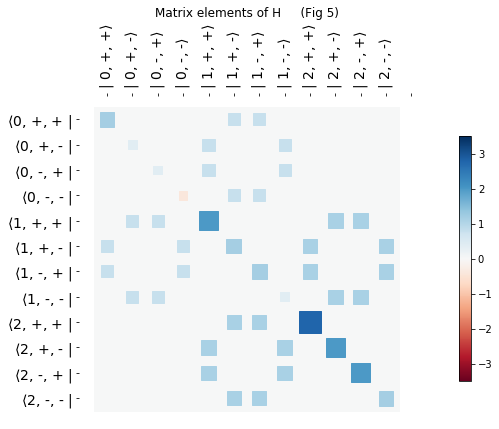

In [109]:
f, ax = hinton(H, xlabels=ket_labels, ylabels=bra_labels)
ax.tick_params(axis='x',labelrotation=90,)
ax.set_title("Matrix elements of H     (Fig 5)");

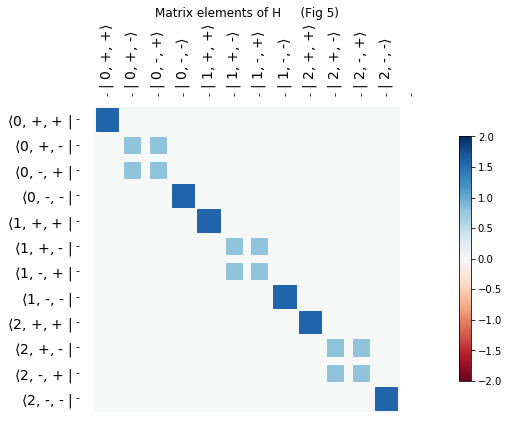

In [110]:
f, ax = hinton(S2, xlabels=ket_labels, ylabels=bra_labels)
ax.tick_params(axis='x',labelrotation=90,)
ax.set_title("Matrix elements of H     (Fig 5)");

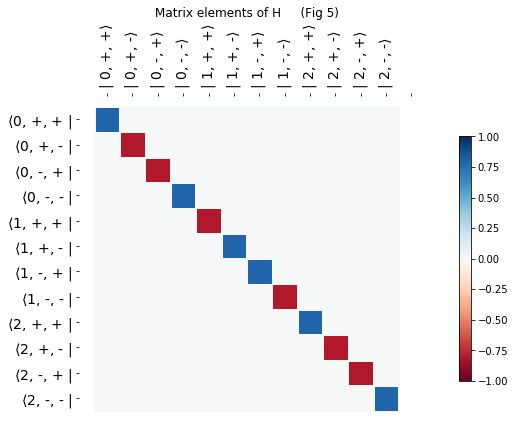

In [111]:
f, ax = hinton(parity, xlabels=ket_labels, ylabels=bra_labels)
ax.tick_params(axis='x',labelrotation=90,)
ax.set_title("Matrix elements of H     (Fig 5)");

In [150]:
H = 2.234*two_state_1+ 2.234*two_state_2 + 1*bosons + 0.001*interaction_1 + 0.001*interaction_2

In [151]:
nm_list

[(0, '+', '+'),
 (0, '+', '-'),
 (0, '-', '+'),
 (0, '-', '-'),
 (1, '+', '+'),
 (1, '+', '-'),
 (1, '-', '+'),
 (1, '-', '-'),
 (2, '+', '+'),
 (2, '+', '-'),
 (2, '-', '+'),
 (2, '-', '-')]

In [152]:
psi0 = basis(len(nm_list), 1)

In [153]:
times = np.linspace(0.0, 10000000.0, 10000) # simulation time
P, psi = simulate(H, psi0, times)

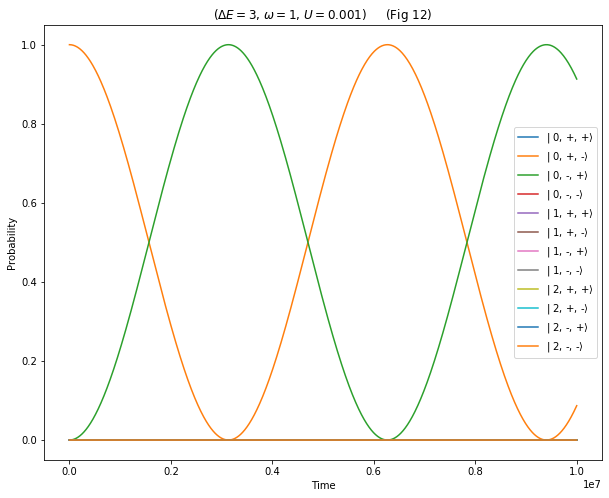

In [154]:
plt.figure(figsize=(10,8))
for i in range(0,P.shape[0]):
    plt.plot(times, P[i,:], label=f"{ket_labels[i]}")
plt.ylabel("Probability")
plt.xlabel("Time")
plt.legend(loc="right")
plt.title("($\Delta E=3$, $\omega=1$, $U=0.001$)     (Fig 12)")
plt.show();

In [159]:
two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nm_list, parity, S2 = make_operators(max_bosons=4)

In [160]:
bra_labels, ket_labels = make_braket_labels(nm_list)

In [161]:
df = make_df_for_energy_scan("$\Delta E$", -4,4, 201, two_state_1.shape[0])

In [162]:
for i, row in df.iterrows():
    H =  row["$\Delta E$"]*two_state_1+ row["$\Delta E$"]*two_state_2 + 1*bosons + 0.001*interaction_1 + 0.001*interaction_2
    evals, ekets = H.eigenstates()
    df.iloc[i,1:] = evals

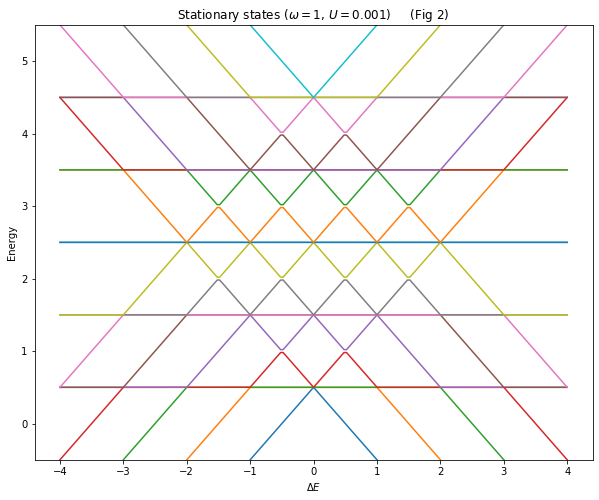

In [163]:
df.plot(x="$\Delta E$",figsize=(10,8),ylim=[-0.5,5.5],legend=False, 
        title="Stationary states ($\omega=1$, $U=0.001$)     (Fig 2)");
plt.ylabel("Energy");

In [164]:
df = make_df_for_energy_scan("$\Delta E$", 2,4, 201, two_state_1.shape[0])
for i, row in df.iterrows():
    H =  row["$\Delta E$"]*two_state_1+ row["$\Delta E$"]*two_state_2 + 1*bosons + 0.001*interaction_1 + 0.001*interaction_2
    evals, ekets = H.eigenstates()
    df.iloc[i,1:] = evals

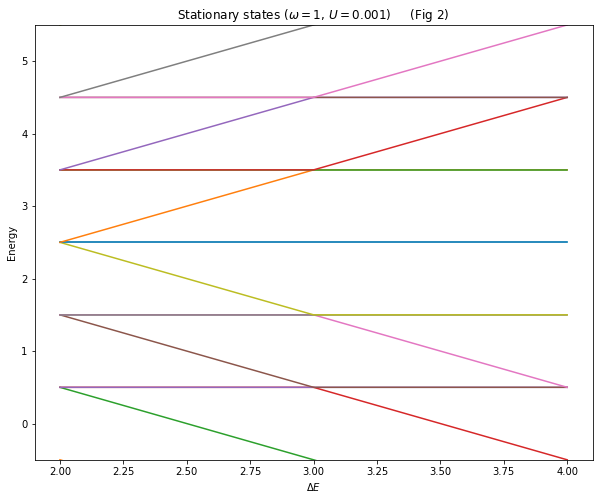

In [165]:
df.plot(x="$\Delta E$",figsize=(10,8),ylim=[-0.5,5.5],legend=False, 
        title="Stationary states ($\omega=1$, $U=0.001$)     (Fig 2)");
plt.ylabel("Energy");

In [166]:
df = make_df_for_energy_scan("$\Delta E$", -4,4, 201, two_state_1.shape[0])
for i, row in df.iterrows():
    H =  row["$\Delta E$"]*two_state_1+ row["$\Delta E$"]*two_state_2 + 1*bosons + 0.2*interaction_1 + 0.2*interaction_2
    evals, ekets = H.eigenstates()
    df.iloc[i,1:] = evals

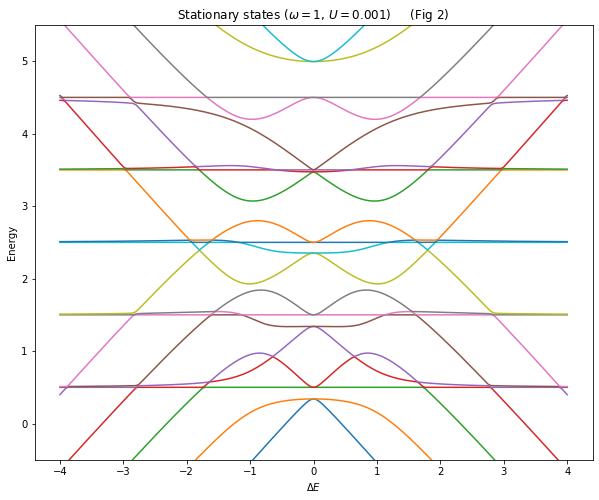

In [167]:
df.plot(x="$\Delta E$",figsize=(10,8),ylim=[-0.5,5.5],legend=False, 
        title="Stationary states ($\omega=1$, $U=0.001$)     (Fig 2)");
plt.ylabel("Energy");

In [168]:
df = make_df_for_energy_scan("$\Delta E$", 2.75,2.8, 201, two_state_1.shape[0])
for i, row in df.iterrows():
    H =  row["$\Delta E$"]*two_state_1+ row["$\Delta E$"]*two_state_2 + 1*bosons + 0.2*interaction_1 + 0.2*interaction_2
    evals, ekets = H.eigenstates()
    df.iloc[i,1:] = evals

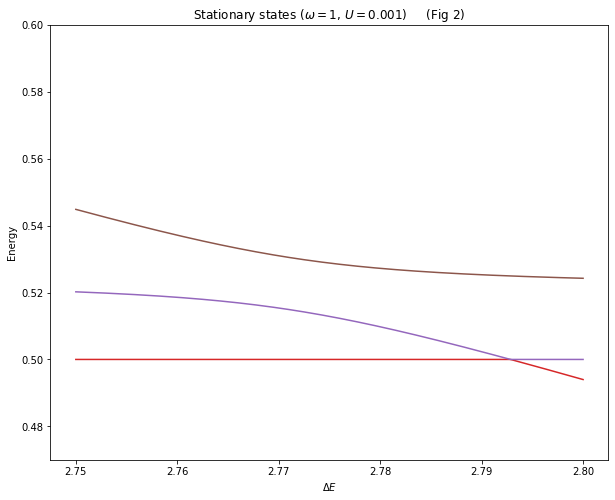

In [169]:
df.plot(x="$\Delta E$",figsize=(10,8),ylim=[0.47,0.6],legend=False, 
        title="Stationary states ($\omega=1$, $U=0.001$)     (Fig 2)");
plt.ylabel("Energy");

In [170]:
# ODD PARITY

two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nm_list, parity, S2 = make_operators(max_bosons=4, parity=-1)

df_odd = make_df_for_energy_scan("$\Delta E$", -4, 4, 201, two_state_1.shape[0])

for i, row in df_odd.iterrows():
    H =  row["$\Delta E$"]*two_state_1+ row["$\Delta E$"]*two_state_2 + 1*bosons + 0.001*interaction_1 + 0.001*interaction_2
    evals, ekets = H.eigenstates()
    df_odd.iloc[i,1:] = evals 

In [171]:
# EVEN PARITY

two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nm_list, parity, S2 = make_operators(max_bosons=4, parity=1)

df_even = make_df_for_energy_scan("$\Delta E$", -4, 4, 201, two_state_1.shape[0])

for i, row in df_even.iterrows():
    H =  row["$\Delta E$"]*two_state_1+ row["$\Delta E$"]*two_state_2 + 1*bosons + 0.001*interaction_1 + 0.001*interaction_2
    evals, ekets = H.eigenstates()
    df_even.iloc[i,1:] = evals 

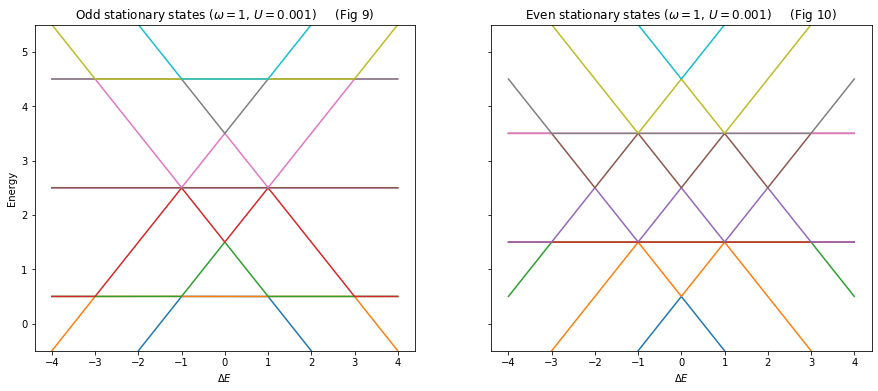

In [172]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6), sharey=True)


df_odd.plot(x="$\Delta E$",ylim=[-0.5,5.5],legend=False, 
        title="Odd stationary states ($\omega=1$, $U=0.001$)     (Fig 9)",  ax=axes[0]);

df_even.plot(x="$\Delta E$",ylim=[-0.5,5.5],legend=False, 
        title="Even stationary states ($\omega=1$, $U=0.001$)     (Fig 10)",  ax=axes[1]);

axes[0].set_ylabel("Energy");

In [173]:
# ODD PARITY

two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nm_list, parity, S2 = make_operators(max_bosons=4, parity=-1)

df_odd = make_df_for_energy_scan("$\Delta E$", -4, 4, 201, two_state_1.shape[0])

for i, row in df_odd.iterrows():
    H =  row["$\Delta E$"]*two_state_1+ row["$\Delta E$"]*two_state_2 + 1*bosons + 0.1*interaction_1 + 0.1*interaction_2
    evals, ekets = H.eigenstates()
    df_odd.iloc[i,1:] = evals 

In [16]:
# EVEN PARITY

two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nm_list, parity, S2 = make_operators(max_bosons=4, parity=1)

df_even = make_df_for_energy_scan("$\Delta E$", -4, 4, 201, two_state_1.shape[0])

for i, row in df_even.iterrows():
    H =  row["$\Delta E$"]*two_state_1+ row["$\Delta E$"]*two_state_2 + 1*bosons + 0.1*interaction_1 + 0.1*interaction_2
    evals, ekets = H.eigenstates()
    df_even.iloc[i,1:] = evals 

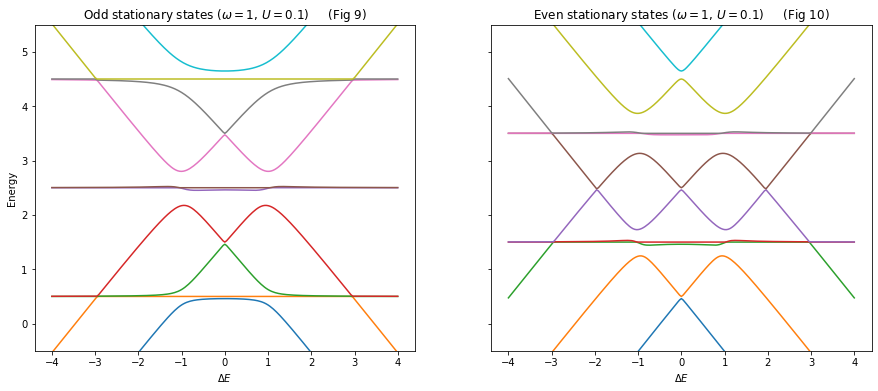

In [175]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6), sharey=True)


df_odd.plot(x="$\Delta E$",ylim=[-0.5,5.5],legend=False, 
        title="Odd stationary states ($\omega=1$, $U=0.1$)     (Fig 9)",  ax=axes[0]);

df_even.plot(x="$\Delta E$",ylim=[-0.5,5.5],legend=False, 
        title="Even stationary states ($\omega=1$, $U=0.1$)     (Fig 10)",  ax=axes[1]);

axes[0].set_ylabel("Energy");

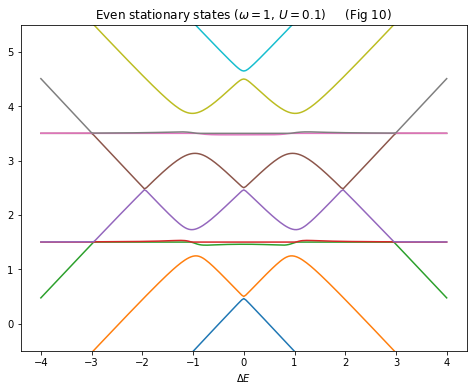

In [27]:
df_even.plot(x="$\Delta E$",ylim=[-0.5,5.5],legend=False,  figsize=(8,6),
        title="Even stationary states ($\omega=1$, $U=0.1$)     (Fig 10)");

In [155]:
two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nm_list, parity, S2 = make_operators(max_bosons=4, parity=-1)


spin = S2.eigenstates()[1]
p   = np.where(S2.eigenenergies()==2)[0]


df_odd = make_df_for_energy_scan("$\Delta E$", -4, 4, 201, p.shape[0])
# df_odd = make_df_for_energy_scan("$\Delta E$", 2.75,2.8, 201, p.shape[0])





for i, row in df_odd.iterrows():
    H =  row["$\Delta E$"]*two_state_1+ row["$\Delta E$"]*two_state_2 + 1*bosons + 0.001*interaction_1 + 0.001*interaction_2
    test = H.transform(S2.eigenstates()[1])
    test = test.extract_states(p)
    evals, ekets = test.eigenstates()
    df_odd.iloc[i,1:] = evals 

In [156]:
nm_list

[(0, '+', '-'),
 (0, '-', '+'),
 (1, '+', '+'),
 (1, '-', '-'),
 (2, '+', '-'),
 (2, '-', '+'),
 (3, '+', '+'),
 (3, '-', '-'),
 (4, '+', '-'),
 (4, '-', '+')]

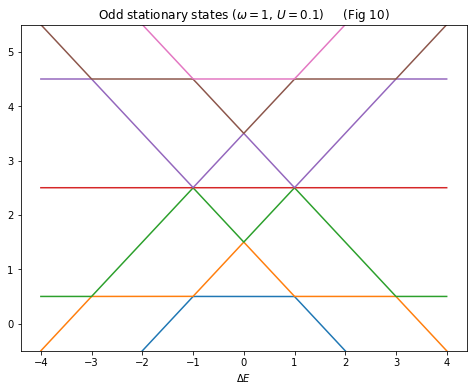

In [78]:
df_odd.plot(x="$\Delta E$",ylim=[-0.5,5.5],legend=False,  figsize=(8,6),
        title="Odd stationary states ($\omega=1$, $U=0.1$)     (Fig 10)");

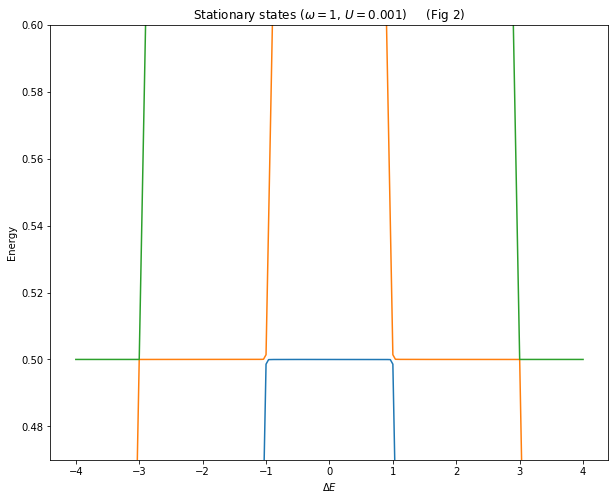

In [77]:
df_odd.plot(x="$\Delta E$",figsize=(10,8),ylim=[0.47,0.6],legend=False, 
        title="Stationary states ($\omega=1$, $U=0.001$)     (Fig 2)");
plt.ylabel("Energy");

>TODO: Need to look at 

https://www2.ph.ed.ac.uk/~ldeldebb/docs/QM/lect15.pdf - addition of angular momentum

https://en.wikipedia.org/wiki/Clebsch%E2%80%93Gordan_coefficients

http://www.lassp.cornell.edu/clh/p654/MM-Lec0.pdf

https://quantummechanics.ucsd.edu/ph130a/130_notes/node312.html

In [38]:
sigmax()**2+sigmay()**2+sigmaz()**2

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[3. 0.]
 [0. 3.]]

In [82]:
sx1 = tensor(sigmax()/2, qeye(2))
sy1 = tensor(sigmay()/2, qeye(2))
sz1 = tensor(sigmaz()/2, qeye(2))

In [83]:
sx2 = tensor(qeye(2), sigmax()/2)
sy2 = tensor(qeye(2), sigmay()/2)
sz2 = tensor(qeye(2), sigmaz()/2)

In [84]:
S2 = (sx1+sx2)**2 + (sy1+sy2)**2 + (sz1+sz2)**2

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x18264c32e8>)

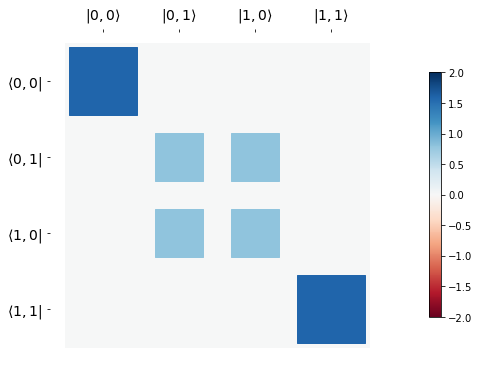

In [85]:
hinton(S2)

In [86]:
S2

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[2. 0. 0. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [0. 0. 0. 2.]]

In [87]:
S2.eigenstates()

(array([1.11022302e-15, 2.00000000e+00, 2.00000000e+00, 2.00000000e+00]),
 array([Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
 Qobj data =
 [[ 0.        ]
  [ 0.70710678]
  [-0.70710678]
  [ 0.        ]],
        Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
 Qobj data =
 [[1.]
  [0.]
  [0.]
  [0.]],
        Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
 Qobj data =
 [[0.        ]
  [0.70710678]
  [0.70710678]
  [0.        ]],
        Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
 Qobj data =
 [[0.]
  [0.]
  [0.]
  [1.]]], dtype=object))

In [88]:
1/np.sqrt(2)

0.7071067811865475